# LBP example visualization for a single image

The best parameters found (with the dataset without noise) are used to visualize what happens to a single image going through all the processing involved in the LBP.

### Imports

In [50]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import local_binary_pattern

### Constants

In [2]:
query_folder = "./data/qsd1_w3/non_augmented/"
bbdd_folder = "./data/BBDD"

### Helper functions

In [71]:
def plot_image(image):
    """
    Displays an image using OpenCV and Matplotlib.
    
    Parameters:
        image (str): the loaded image.
    """
    # 1D color channelimage
    if len(image.shape)==2:
        plt.imshow(image, cmap="gray")
    # 3D color channel image
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

def split_image_into_quadrants(image, level):
    if level == 0:
        return [image]
    height, width, *rest = image.shape
    center_x, center_y = width // 2, height // 2

    # Split image into quadrants
    top_left = image[0:center_y, 0:center_x]
    top_right = image[0:center_y, center_x:width]
    bottom_left = image[center_y:height, 0:center_x]
    bottom_right = image[center_y:height, center_x:width]

    # Recursively split each quadrant
    top_left_quadrants = split_image_into_quadrants(top_left, level - 1)
    top_right_quadrants = split_image_into_quadrants(top_right, level - 1)
    bottom_left_quadrants = split_image_into_quadrants(bottom_left, level - 1)
    bottom_right_quadrants = split_image_into_quadrants(bottom_right, level - 1)

    # Calculate the number of tiles per row at this level
    tiles_per_row = 2 ** (level - 1)

    # Combine quadrants in row-major order so they can be plotted correctly
    top_row = []
    bottom_row = []
    for i in range(0, len(top_left_quadrants), tiles_per_row):
        top_row.extend(top_left_quadrants[i:i+tiles_per_row] + top_right_quadrants[i:i+tiles_per_row])
    for i in range(0, len(bottom_left_quadrants), tiles_per_row):
        bottom_row.extend(bottom_left_quadrants[i:i+tiles_per_row] + bottom_right_quadrants[i:i+tiles_per_row])

    return top_row + bottom_row

def plot_quadrants(quadrants, save=False):
    # Calculate the grid size
    num_quadrants = len(quadrants)
    grid_size = int(num_quadrants ** 0.5)
    
    # Create the plot
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    
    # Plot each quadrant
    for i, quadrant in enumerate(quadrants):
        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(quadrant, cmap="gray")
        ax.axis('off')
    
    if save:
        plt.savefig("quadrants.jpg")
    plt.tight_layout()
    plt.show()

def compute_block_lbp(block, radius, n_points, method):
    """
    Compute the LBP histogram for a single block of the image.
    """
    lbp = local_binary_pattern(block, n_points, radius, method=method)
    
    if method=="uniform":
        # Compute LBP histogram with uniform method (bins range from 0 to n_points + 2)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    else:
        # Compute LBP histogram with default or ror method
        hist, _ = np.histogram(lbp.ravel(), bins=2**n_points, density=True)
        
    return hist, lbp

### 1. The image is loaded

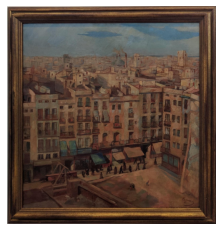

Shape: (1684, 1616, 3)


In [72]:
# Path to example image of choice
image_path = os.path.join(query_folder, "00017.jpg")
image = cv2.imread(image_path)

plot_image(image)
print("Shape:", image.shape)

### 2. The image color space is transformed to a one dimensional color space (L from CIELAB in this case)

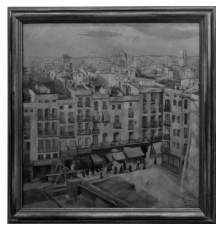

Shape: (1684, 1616)


In [73]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
L_channel = image[:, :, 0]

plot_image(L_channel)
print("Shape:", L_channel.shape)

### 3. The image is resized to 256x256

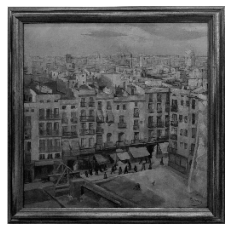

Shape: (256, 256)


In [74]:
L_channel = cv2.resize(L_channel, (256, 256))

plot_image(L_channel)
print("Shape:", L_channel.shape)

### 4. The image is split into blocks (16 blocks in this case, 64x64 pixels each)

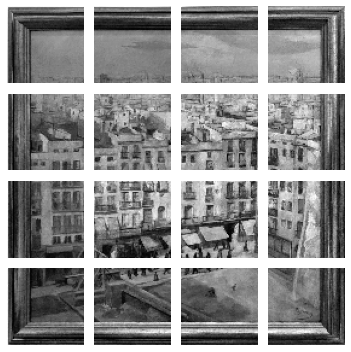

In [75]:
quadrants = split_image_into_quadrants(np.expand_dims(L_channel, axis=-1), 2)
plot_quadrants(quadrants)

### 5. The LBP is calculated for each block

In [86]:
n_blocks = 16
radius = 3
n_points = 12
method = "default"

# Divide the image into blocks
blocks = split_image_into_quadrants(L_channel, 2)

# Compute LBP for each block and concatenate histograms
histograms = []
lbp_images = []
for block in blocks:
    block_histogram, lbp_image = compute_block_lbp(block, radius, n_points, method)
    histograms.append(block_histogram)
    lbp_images.append(lbp_image)

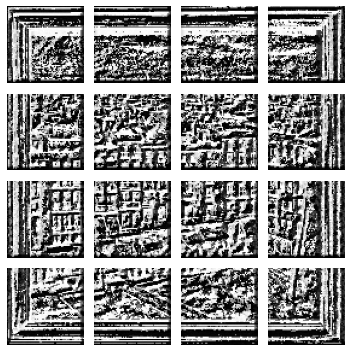

In [92]:
plot_quadrants(lbp_images)

### 6. A histogram is extracted for each block ($2^{num\_points}=2^{12}=4096$ bins)

In [136]:
def plot_histograms(array_list):
    """
    Plots 16 histograms in a 4x4 grid, where each histogram corresponds to a numpy array in the list.
    
    Parameters:
    array_list (list of np.array): List containing 16 numpy arrays.
    """
    # Check if the input list has 16 arrays
    if len(array_list) != 16:
        raise ValueError("The list must contain exactly 16 numpy arrays.")
    
    # Create a 4x4 grid for the histograms
    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    fig.suptitle('4x4 Grid of Histograms', fontsize=16)
    
    # Flatten the 4x4 grid to easily iterate through the axes
    axs = axs.ravel()

    # Plot each array as a histogram
    for i in range(16):
        axs[i].plot(array_list[i], color='blue', alpha=0.7)
        axs[i].set_ylabel('Frequency')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top space for the main title
    plt.show()


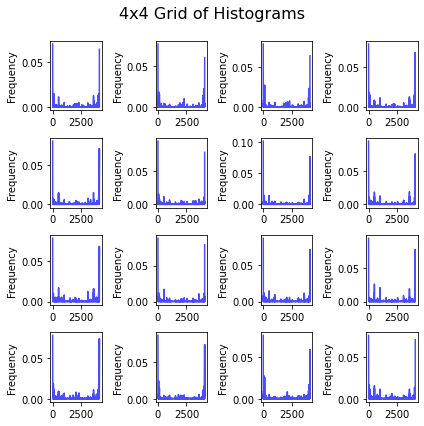

In [137]:
plot_histograms(concatenated_histogram)

### 7.  The histograms are concatenated, forming a histogram with 65536 bins

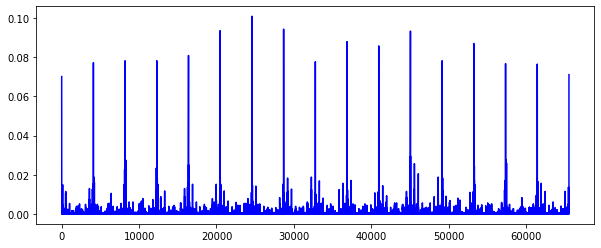

In [139]:
plt.figure(figsize=(10, 4))
hist = plt.plot(np.concatenate(concatenated_histogram), color="blue")

These histograms are then compared to perform the image retrieval